This Notebook is doing the same thing as NB2 but for the northern region. If you want to run the code in this repo, run this before NB2 to create the CSVs. 

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.feature import blob_dog
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.measure import regionprops
import regions as rg
import astropy.units as u
from astropy.nddata.utils import Cutout2D
import scipy.ndimage
import sys as os
os.path.append("%SURP_DIR%/RawData")

In [2]:
hdulist = fits.open("M82_JWST_reduced.fits")
header = hdulist[0].header
imdat = hdulist[0].data
print(type(imdat))
image_whole = imdat
wcs = WCS(hdulist[0].header)

<class 'numpy.ndarray'>


Set DATE-AVG to '2023-12-31T19:43:39.963' from MJD-AVG.
Set DATE-END to '2024-01-01T01:32:08.328' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to     8.864333 from OBSGEO-[XYZ].
Set OBSGEO-H to 1694877744.107 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


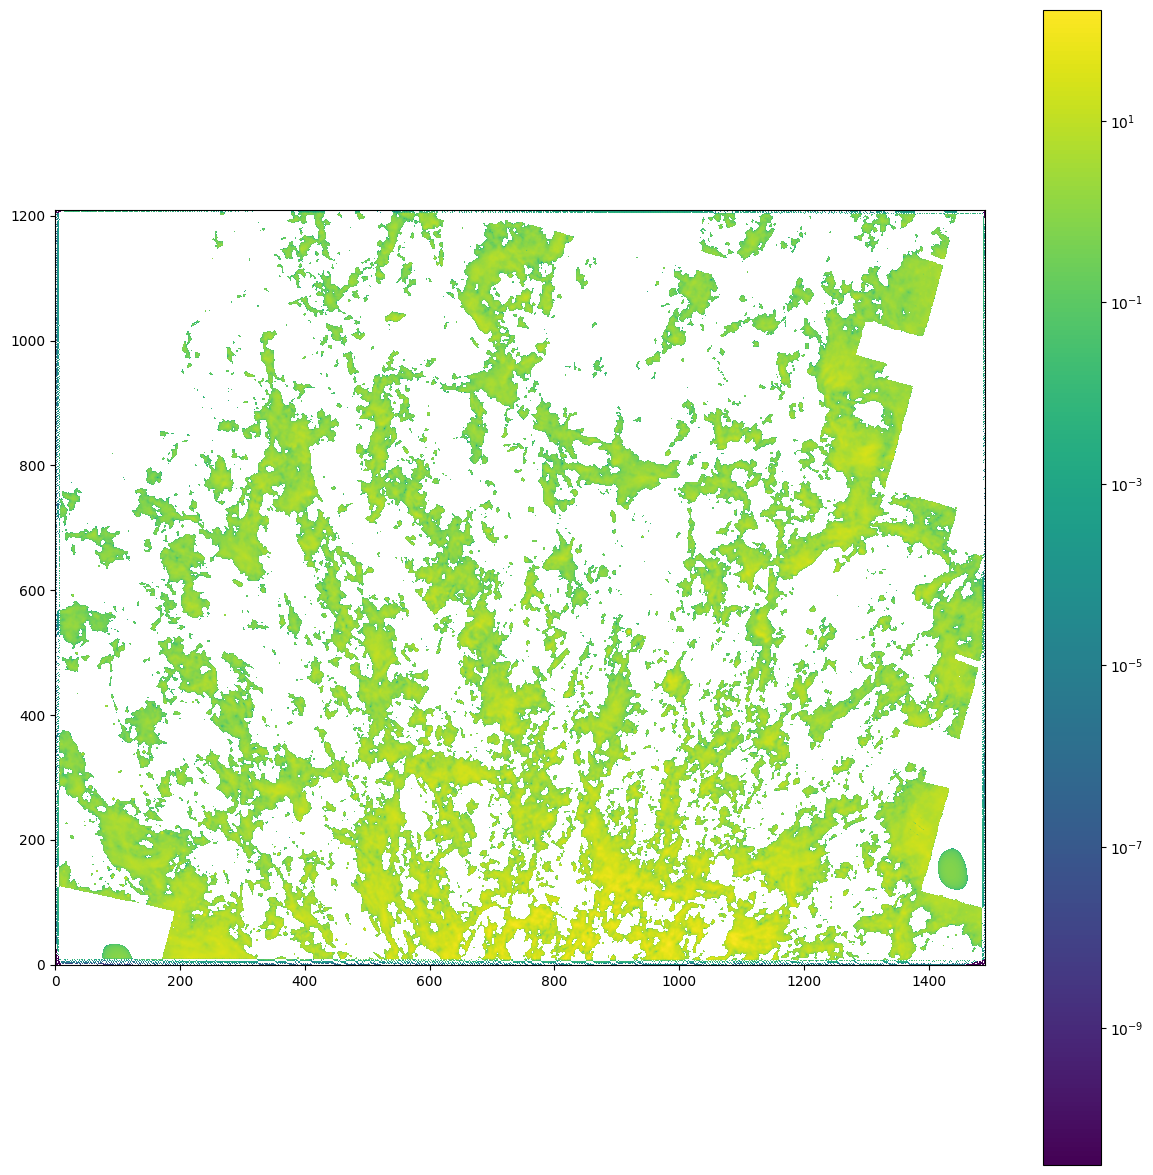

(298, 3)
(1210, 1490, 3)


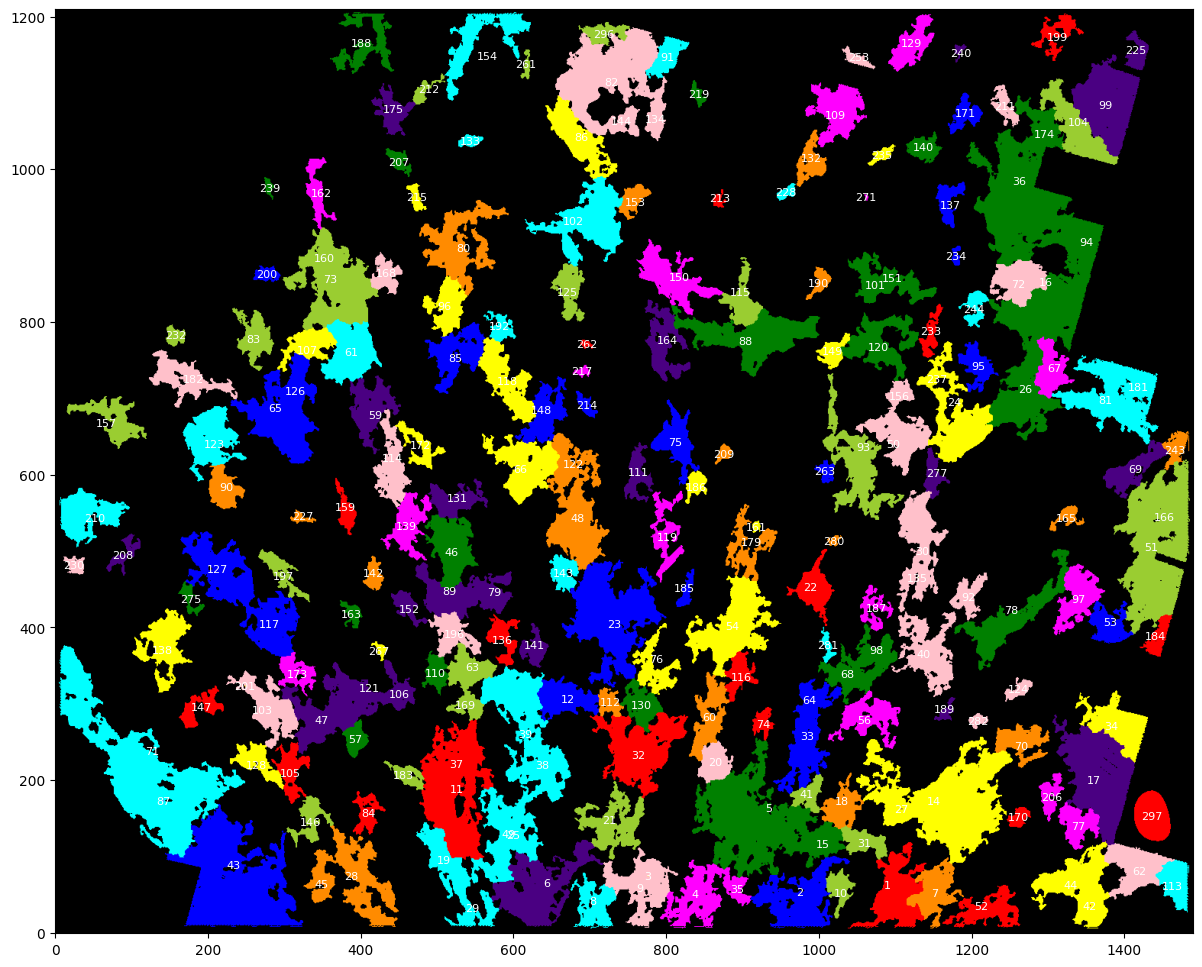

In [3]:
test_reg = rg.Regions.read('./M82_JWST_regions.reg', format="ds9")
reg_str = ['south','north']

#for largereg,rgname in zip(test_reg,reg_str):

reg1 = test_reg[1]
mask = reg1.to_mask()
data = mask.cutout(image_whole)

size = u.Quantity(data.shape, u.pixel)
cutout = Cutout2D(imdat, reg1.center.xy, size, wcs=wcs)
im_mask= mask*cutout.data

rotated_im = scipy.ndimage.rotate(im_mask, angle=-15, reshape=False)
fig, ax = plt.subplots(figsize=(15,15))


non_zero_indecies = np.where(rotated_im > 0.0001)
min_x, max_x = np.min(non_zero_indecies[1]), np.max(non_zero_indecies[1])
min_y, max_y = np.min(non_zero_indecies[0]), np.max(non_zero_indecies[0])
rotated_im = rotated_im[min_y:max_y+1, min_x:max_x+1]
imax = ax.imshow(rotated_im ,origin='lower', norm=LogNorm())
fig.colorbar(imax)
plt.show()
plt.close()

blobs = blob_dog(rotated_im, min_sigma=15, max_sigma=50, threshold=0.001)

fig, ax = plt.subplots(figsize=(16,12))
# Convert blob coordinates to integers
blobs = np.round(blobs).astype(int)
print(blobs.shape)
# Create a labeled array for the blobs
labeled_clumps = np.zeros_like(rotated_im, dtype=int)
# Assign unique labels to the blobs

for i, (y, x, sigma) in enumerate(blobs):
    labeled_clumps[y,x] = i + 1

segmentationNorth = watershed(-rotated_im, labeled_clumps, mask=(rotated_im > 0.001))
#bad_values = []
#for i in bad_values:
#     segmentationNorth = np.where(segmentationNorth != i, segmentationNorth, 0)
seg_overlay = label2rgb(segmentationNorth, bg_label=0)
print(np.shape(seg_overlay))
im = ax.imshow(seg_overlay, origin='lower')
for label_value in np.unique(segmentationNorth):

        if label_value == 0:
            continue  # Skip the background label
        # Extract coordinates of the labeled component
        coords = np.argwhere(segmentationNorth == label_value)
        # Find the bounding box
        min_y, min_x = np.min(coords, axis=0)
        max_y, max_x = np.max(coords, axis=0)
        # Calculate the center of the bounding box
        y, x = (min_y + max_y) / 2, (min_x + max_x) / 2
        plt.text(x, y, str(label_value), color='white', fontsize=8, ha='center', va='center')


In [4]:
subImageN = np.zeros_like(rotated_im)
numBlobs = np.max(segmentationNorth)
print(numBlobs)
index = 0
label_coords = []
for j in range(1,numBlobs):
    testBlob = np.where(segmentationNorth == j, rotated_im, 0)
    subblobs = blob_dog(testBlob, min_sigma=1, max_sigma=5, threshold=0.001)
    subblobs = np.round(subblobs).astype(int)
    labeled_clumps = np.zeros_like(testBlob, dtype=int)
    # Assign unique labels to the blobs

    for i, (y, x, sigma) in enumerate(subblobs):
        labeled_clumps[y,x] = index + 1
        index = index+1
    subSegmentation = watershed(-testBlob, labeled_clumps, mask=(testBlob > 0.001))
    #subOverlay = label2rgb(subSegmentation, bg_label=0)
    subImageN = subImageN+subSegmentation
subOverlay = label2rgb(subImageN, bg_label = 0)


#for label_value in np.unique(subSegmentation):
# Extract coordinates of the labeled component





297


Text(0, 0.5, 'Count')

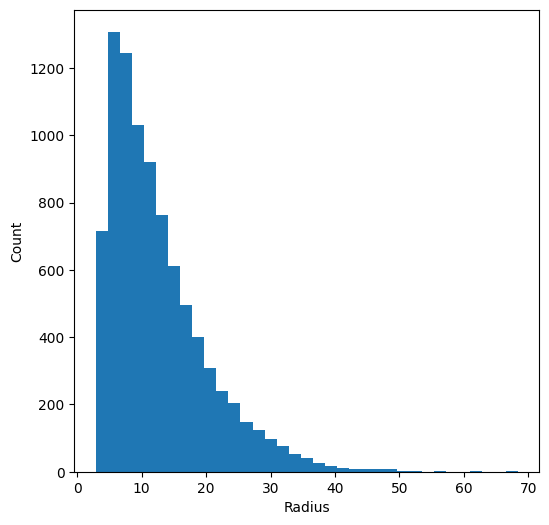

In [5]:
unique, counts = np.unique(subImageN, return_counts = True)
imageCounts = dict(zip(unique, counts))
testArray = subImageN
for i in imageCounts:
    if imageCounts[i] < 4:
        testArray = np.where(testArray!= i, testArray, 0)
ellipsStats = regionprops(testArray.astype(dtype=int))
axesPx = []
for i in ellipsStats:
    if i.axis_minor_length == 0:
        continue
    axesPx.append((i.axis_major_length, i.axis_minor_length, i.label))
axes = [(i[0]*(5/3), i[1]*(5/3), i[2]) for i in axesPx]
#print("Axes:", axes)
volumes = []
for i in axes:
    V = (4/3)*np.pi*i[0]*i[1]*i[1]
    volumes.append(V)
#print("Volume: ", volumes)
sphereRadii = []
for i in volumes:
    R = ((3*i)/(4*np.pi))**(1/3)
    sphereRadii.append(R)
#print(sphereRadii)
fig, ax = plt.subplots(figsize = (6, 6))
ax.hist(sphereRadii, bins=35)
ax.set_xlabel("Radius")
ax.set_ylabel("Count")

In [6]:
numDensity = []
colDensity = []
cloudLabels = []
print(np.unique(testArray.astype(dtype=int)))
print(len(axes))
for i in axesPx:
    reg = np.where(testArray == i[2], rotated_im, 0) #Uses the label to mask all of the raw image except for the cloud
    I = np.sum(reg)
    n = 5.54*(I**1.15)/(i[1]) #Calculate number density (i[1] is the minor axis)
    N = 0.285*(10**20)*(I**1.15)
    colDensity.append(N)
    numDensity.append(n) 
    cloudLabels.append(i[2])

[   0    1    2 ... 9590 9591 9592]
8872


In [7]:
YOFFSET = 396.2
XORIGIN = 824.1
YORIGIN = 0
print(np.shape(subImageN))

relCords = []
for i in axesPx: 

    if i[2] == 0:
        continue
    coords = np.argwhere(subImageN == i[2]) #Gets coordinates of cloud pixels
    min_y, min_x = np.min(coords, axis=0)
    max_y, max_x = np.max(coords, axis=0)
    y, x = ((min_y + max_y)/2-YORIGIN), ((min_x+max_x)/2)-XORIGIN #Calculates coordinates to the closest point in the image to the center
    relCords.append([x, y, i[2]])

(1210, 1490)


In [8]:
pcCords = []
for i in relCords:
    x, y = (5/3)*i[0], (5/3)*i[1] #Convert from pixels to parsecs
    pcCords.append([x, y, i[2]])
dist = []
for i in pcCords:
    d = np.sqrt((i[0]**2)+((i[1]+YOFFSET)**2)) #Calculate distance. The galactic center is not in the image, so we add the distance to the center here
    dist.append(d)


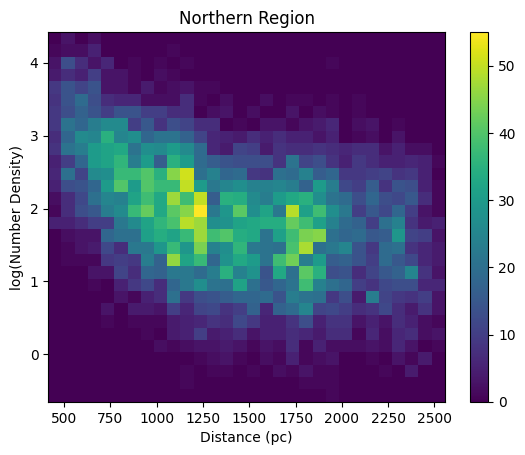

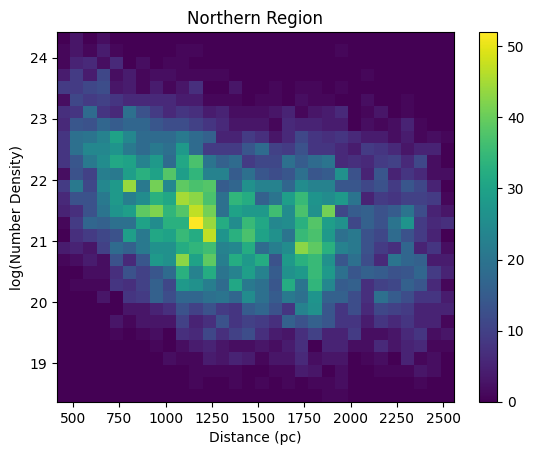

In [9]:
fig, ax = plt.subplots() #This is a plotting cell
lDense = [np.log10(i) for i in numDensity]
h = ax.hist2d(dist, lDense, bins=(30, 30))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Northern Region")
fig.colorbar(h[3])
#plt.savefig("Northern2dHist.png", format="png")
normDensity = [] 
for i in range(len(numDensity)):
    #norm = int(np.ceil(255*numDensity[i]/np.max(numDensity)))
    norm = numDensity[i]
    normDensity.append([norm, cloudLabels[i]])
plt.savefig("Northern2dHist.png")

fig, ax = plt.subplots()
h = ax.hist2d(dist, np.log10(colDensity), bins=(30, 30))
ax.set_xlabel("Distance (pc)")
ax.set_ylabel("log(Number Density)")
plt.title("Northern Region")
fig.colorbar(h[3])

In [10]:
np.savetxt("NorthDensities.csv", numDensity, delimiter=",", fmt="%f") #Save data to CSVs to be used later
np.savetxt("NorthDistances.csv", dist, delimiter=",", fmt="%f")
np.savetxt("NorthColDensity.csv", colDensity, delimiter=",", fmt="%f")
np.savetxt("NorthRadii.csv", sphereRadii, delimiter=',', fmt="%f")